In [1]:
import uproot as ur
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors

import mplhep as hep
hep.style.use("CMS")

plt.rcParams['figure.facecolor']='white'
plt.rcParams['savefig.facecolor']='white'
plt.rcParams['savefig.bbox']='tight'
plt.rcParams['legend.frameon']=True
plt.rcParams['legend.edgecolor']='white'
import uproot,glob,ROOT

from scipy.optimize import curve_fit

plt.rcParams["figure.figsize"] = (10, 8)

import gc
pdg=ROOT.TDatabasePDG()

Welcome to JupyROOT 6.28/04


In [2]:
import generator

In [3]:
#Du et al calculations.
# use these to build a binary search table to get a realistic
# distribution in nu
from io import StringIO
import pandas as pd
calc_str = StringIO("""nu,nb
    8.716,6.918
    8.730,18.239
    8.748,25.786
    8.766,30.818
    8.787,36.478
    8.816,42.767
    8.858,50.314
    8.922,59.748
    8.982,66.667
    9.060,74.214
    9.191,84.277
    9.330,92.453
    9.475,99.371
    9.660,106.289
    9.858,111.321
    10.064,115.723
    10.376,120.126
    10.585,122.013
    10.599,122.013
    """)

df_calc = pd.read_csv(calc_str, sep=",")

In [4]:
#custom generator using the PDF from Du et al,
#and a realistic Q2 distribution

D0bar=pdg.GetParticle(-421)
lcp=pdg.GetParticle(4122)
m_D0bar=D0bar.Mass()
m_lcp=lcp.Mass()
class CustomGenerator():
    def __init__(self, Ebeam=10.6, photon_pdf_points=df_calc, min_electron_energy=0.5):
        
        mp=0.9383
        me=0.000511
        
        self._Ebeam=Ebeam
        self._P0=ROOT.TLorentzVector(0,0,Ebeam, np.hypot(Ebeam,me)+mp)
        
        self.photon_pdf_points=photon_pdf_points
        alpha=1/137.
        threshold=8.7
        Ee_min=0.5
        nu=photon_pdf_points.nu
        y=nu/10.6
        thetae_max, thetae_min=np.array((4.5,2.5))*np.pi/180
        tmax=4*Ebeam**2*(1-y)*np.sin(thetae_max/2)**2
        tmin=4*Ebeam**2*(1-y)*np.sin(thetae_min/2)**2
        me=0.000511
        f=alpha/np.pi*((1-y+1/2*y**2)*np.log(tmax/tmin)+me**2*y**2*(1/tmax-1/tmin))/y
        ds_dnu=photon_pdf_points.nb*f
        self._nu=np.linspace(threshold,Ebeam-min_electron_energy, 1024+2)[1:-1]
        self._cdf=[]
        #create interpolation points
        for i in range(len(self._nu)): 
            c=0
            ii=1
            while nu[ii]< self._nu[i]:
                c+=(ds_dnu[ii]+ds_dnu[ii-1])/2*(nu[ii]-nu[ii-1])
                ii+=1
            dx=(self._nu[i]-nu[ii-1])
            c+=dx*ds_dnu[ii-1]+dx*dx*(ds_dnu[ii]-ds_dnu[ii-1])/(2*(nu[ii]-nu[ii-1]))
            self._cdf.append(c)
        self._cdf=np.array(self._cdf)/self._cdf[-1]
    def next(self):
        #create the scattered electron 4 vector.  
        #first determine nu
        u = rand.uniform(0, 1)
        i=512
        di=256
        while di >=1:
            if (u> self._cdf[i]):
                i+=di
            else :
                i -=di
            di=di//2
        nu=self._nu[i]
        #dsigma dtheta is approximately 
        theta=np.exp(rand.uniform(np.log(2.5*np.pi/180), np.log(4.5*np.pi/180)))
        E=self._Ebeam-nu
        phi=rand.uniform(0,2*np.pi)
        p=np.sqrt(E**2-me**2)
        e= ROOT.TLorentzVector(p*np.sin(theta)*np.cos(phi), p*np.sin(theta)*np.sin(phi), p*np.cos(theta),
                              E)
        h=self._P0-e
        return e,h
    

In [5]:
Ebeam=10.6

mp=.9383
mn=.9396
mD0=1.86484
mLambdaC=2.28646
mLambda=1.115683
me=0.000511
mMu=0.1057
mpi_charged = 0.1396
mpi0 = 0.1350
mK=.493677

stot = (Ebeam+mp)**2-Ebeam**2
x1 = mD0**2/stot
x2 = 0.000511**2/stot
x3 = mLambdaC**2/stot

#ep_to_d0_e_lambdac= generator.oneToThreeGenerator(P0.M(), mD0, me, mLambdaC)
#ep_to_d0_e_lambdac= generator.PhotoproductionGenerator(P0.M(), mD0, me, mLambdaC)

#create generator subsystems... 
custom_generator=CustomGenerator()
h_to_D0bar_lambdac = generator.oneToTwoGenerator(None, mD0, mLambdaC)
lambdac_decay = generator.oneToThreeGenerator(mLambdaC, mK,  mpi_charged, mp)

D0bar_decay = generator.oneToTwoGenerator(mD0, mK, mpi_charged)

s13 range: 0.3922336675716795 0.8816175613292485


In [6]:
%%time
import math 
D0bar=pdg.GetParticle(-421)
lcp=pdg.GetParticle(4122)

doverp={}

doverp["D0"]=299792458*1000*4.101e-13/D0bar.Mass()
doverp["lambdac"]=299792458*1000*2.024e-13/lcp.Mass()
rand=generator.rand


d1 = {a+"_"+b:[] for a in "D0 e lambdac Kp Km pip pim p".split() for b in "E px py pz p theta phi".split()}
for part in 'lambdac D0'.split():
    for a in 'xyz':
        d1[f'{part}_v{a}']=[]
for i in range(100000):
    #if an invalid event is created, replace it
    
    while True :
        d = {}
        d["e"],h = custom_generator.next()
        d["D0"],d["lambdac"]= h_to_D0bar_lambdac.next(h)
        #print(d['D0'].Px())
        d["Km"],d["pip"],d["p"] = lambdac_decay.next(d["lambdac"])
        #print((d["Km"]+d["pip"]+d["p"]).M())
        d["Kp"],d["pim"] = D0bar_decay.next(d["D0"])
        badEvent=False
        for p in d.values():
            if math.isnan(p.E()) or math.isnan(p.Px()) or math.isnan(p.Py()) or math.isnan(p.Pz()):
                badEvent=True
                break
        if not badEvent:
            break
    
    for key in d.keys():
        d1[key + "_E"].append(d[key].E())
        d1[key + "_px"].append(d[key].Px())
        d1[key + "_py"].append(d[key].Py())
        d1[key + "_pz"].append(d[key].Pz())
        d1[key + "_p"].append(d[key].P())
        d1[key + "_theta"].append(d[key].Theta())
        d1[key + "_phi"].append(d[key].Phi())
    for part in 'lambdac D0'.split():
        p=d[part].Vect()
        vertex=rand.expovariate(1)*doverp[part]*p
        #print(vertex.Mag())
        p=d[key].Vect()
        d1[f'{part}_vx'].append(vertex.X())
        d1[f'{part}_vy'].append(vertex.Y())
        d1[f'{part}_vz'].append(vertex.Z())
    if i%100==0:
        print(f"{i} events generated")
df_sim = pd.DataFrame(d1)

0 events generated
100 events generated
200 events generated
300 events generated
400 events generated
500 events generated
600 events generated
700 events generated
800 events generated
900 events generated
1000 events generated
1100 events generated
1200 events generated
1300 events generated
1400 events generated
1500 events generated
1600 events generated
1700 events generated
1800 events generated
1900 events generated
2000 events generated
2100 events generated
2200 events generated


/Users/spaul/charm_studies/generator.py:26: RuntimeWarning: invalid value encountered in sqrt
  p = np.sqrt(self.m1**4+self.m2**4+m0**4-2*self.m1**2*m0**2-2*self.m1**2*self.m2**2-2*m0**2*self.m2**2)/(2*m0)


2300 events generated
2400 events generated
2500 events generated
2600 events generated
2700 events generated
2800 events generated
2900 events generated
3000 events generated
3100 events generated
3200 events generated
3300 events generated
3400 events generated
3500 events generated
3600 events generated
3700 events generated
3800 events generated
3900 events generated
4000 events generated
4100 events generated
4200 events generated
4300 events generated
4400 events generated
4500 events generated
4600 events generated
4700 events generated
4800 events generated
4900 events generated
5000 events generated
5100 events generated
5200 events generated
5300 events generated
5400 events generated
5500 events generated
5600 events generated
5700 events generated
5800 events generated
5900 events generated
6000 events generated
6100 events generated
6200 events generated
6300 events generated
6400 events generated
6500 events generated
6600 events generated
6700 events generated
6800 event

38500 events generated
38600 events generated
38700 events generated
38800 events generated
38900 events generated
39000 events generated
39100 events generated
39200 events generated
39300 events generated
39400 events generated
39500 events generated
39600 events generated
39700 events generated
39800 events generated
39900 events generated
40000 events generated
40100 events generated
40200 events generated
40300 events generated
40400 events generated
40500 events generated
40600 events generated
40700 events generated
40800 events generated
40900 events generated
41000 events generated
41100 events generated
41200 events generated
41300 events generated
41400 events generated
41500 events generated
41600 events generated
41700 events generated
41800 events generated
41900 events generated
42000 events generated
42100 events generated
42200 events generated
42300 events generated
42400 events generated
42500 events generated
42600 events generated
42700 events generated
42800 event

74700 events generated
74800 events generated
74900 events generated
75000 events generated
75100 events generated
75200 events generated
75300 events generated
75400 events generated
75500 events generated
75600 events generated
75700 events generated
75800 events generated
75900 events generated
76000 events generated
76100 events generated
76200 events generated
76300 events generated
76400 events generated
76500 events generated
76600 events generated
76700 events generated
76800 events generated
76900 events generated
77000 events generated
77100 events generated
77200 events generated
77300 events generated
77400 events generated
77500 events generated
77600 events generated
77700 events generated
77800 events generated
77900 events generated
78000 events generated
78100 events generated
78200 events generated
78300 events generated
78400 events generated
78500 events generated
78600 events generated
78700 events generated
78800 events generated
78900 events generated
79000 event

In [7]:
#set the daughter particle positions to match that of the mothers
for m, ds in ("D0", ("Kp","pim")), ("lambdac", ("Km", "pip","p")):
    for d in ds:
        for a in "xyz":
            df_sim[f'{d}_v{a}']=df_sim[f'{m}_v{a}']

#electron vertex is at (0,0,0)
for a in "xyz":
    df_sim[f'e_v{a}']=0*df_sim[f'D0_v{a}']

In [20]:
df_sim.to_pickle("D0bar_lcp_sim.pkl")

In [8]:
def toLund(df, filename, split=None):
    #if using the "split" option, create a directory and fill it with files from sub indices
    if split is not None:
        import os
        try:
            os.mkdir(filename)
        except:
            pass
        for i in range(split):
            toLund(df[len(df)//split*i: len(df)//split*(i+1)].reset_index(drop=True), 
                   f"{filename}/{filename}_{i}.lund")
        return
    fields = df.columns
    with open(filename, "w") as f:
        for i in range(len(df)):
#             1 Number of particles
#             2 Mass number of the target (UD)
#             3 Atomic number oif the target (UD)
#             4 Target polarization (UD)
#             5 Beam Polarization
#             6 Beam type, electron=11, photon=22” (UD)
#             7 Beam energy (GeV) (UD)
#             8 Interacted nucleon ID (2212 or 2112) (UD)
#             9 Process ID (UD)
#             10 Event weight (UD)
            
            print(6, 1, 1,0, 0, 11,Ebeam,2212, 0, 1, file=f)
            for j,(particle_name, pid) in enumerate([("e", 11), 
                                                     ("pip", 211), 
                                                     ("pim", -211),
                                                     ("Kp", 321),
                                                     ("Km", -321),
                                                     ("p",2212),
                                                    ]):
                particle = pdg.GetParticle(pid)
                print(j+1, particle.Lifetime()/1e9, 1, pid, 0,0, 
                      df[particle_name + "_"+"px"][i], 
                      df[particle_name + "_"+"py"][i],
                      df[particle_name + "_"+"pz"][i],
                      df[particle_name + "_"+"E"][i],
                      particle.Mass(), 
                      df[particle_name + "_vx"][i]/10,
                      df[particle_name + "_vy"][i]/10,
                      df[particle_name + "_vz"][i]/10, 
                         file=f)

In [9]:
toLund(df_sim, "D0bar_lcp_sim", 100)

# checks

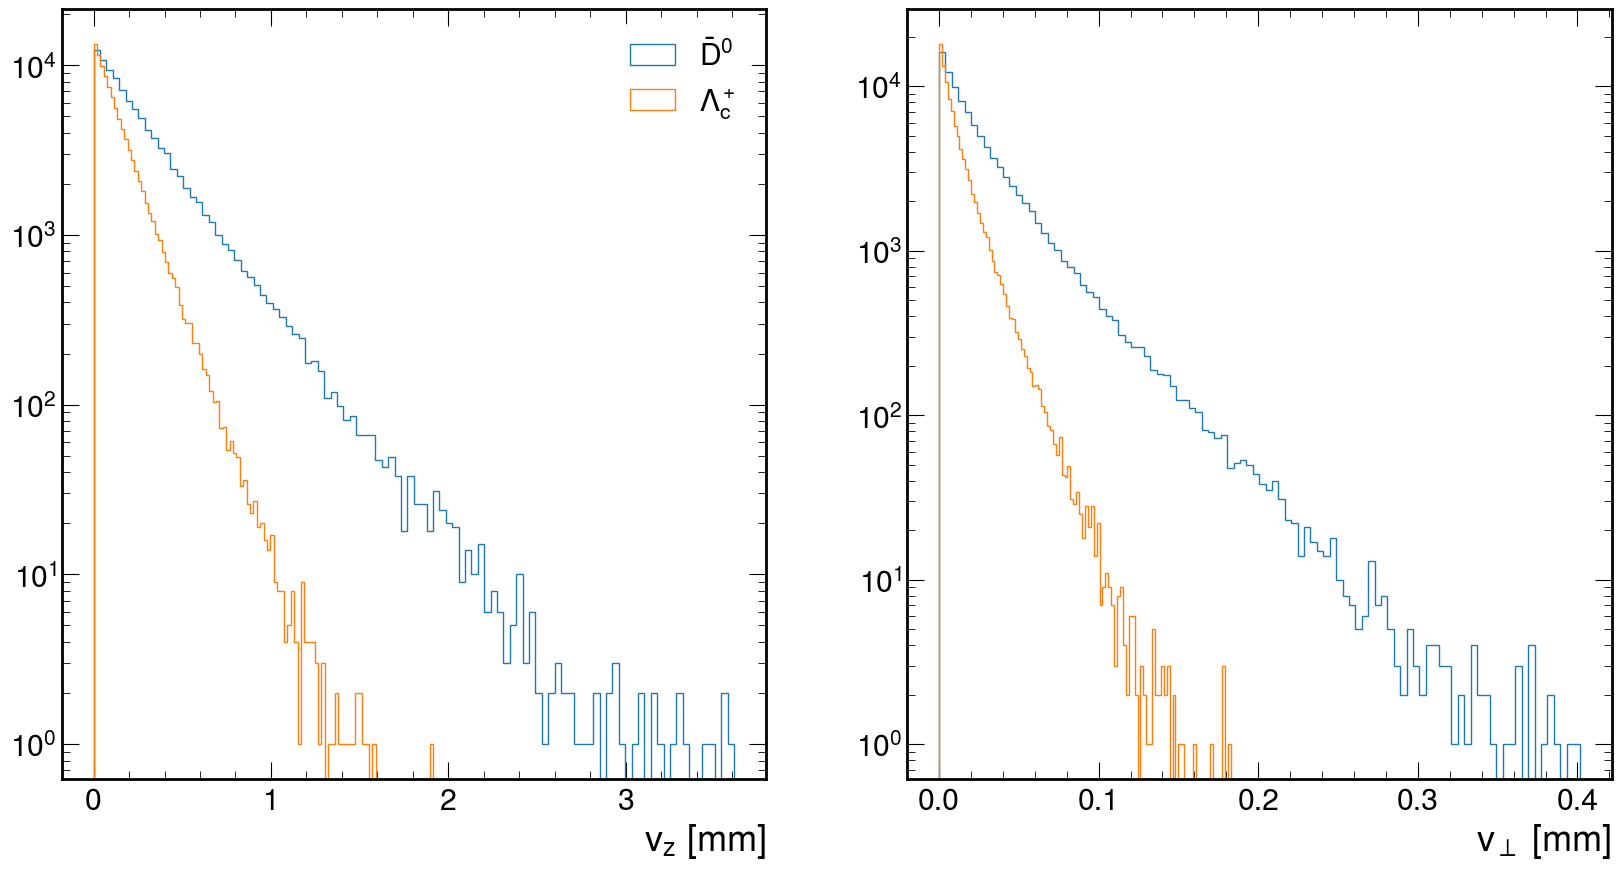

In [10]:
fig, axs=plt.subplots(1,2, figsize=(20,10))
plt.sca(axs[0])
plt.hist(df_sim.D0_vz, bins=100, histtype='step', label="$\\bar D^0$")
plt.hist(df_sim.lambdac_vz, bins=100, histtype='step', label="$\\Lambda_c^+$")
plt.xlabel("$v_z$ [mm]")
plt.yscale('log')
plt.legend()
plt.sca(axs[1])
plt.hist(df_sim.eval("sqrt(D0_vx**2+D0_vy**2)"), bins=100, histtype='step')
plt.hist(df_sim.eval("sqrt(lambdac_vx**2+lambdac_vy**2)"), bins=100, histtype='step')
plt.xlabel("$v_\\perp$ [mm]")
plt.yscale('log')
plt.show()

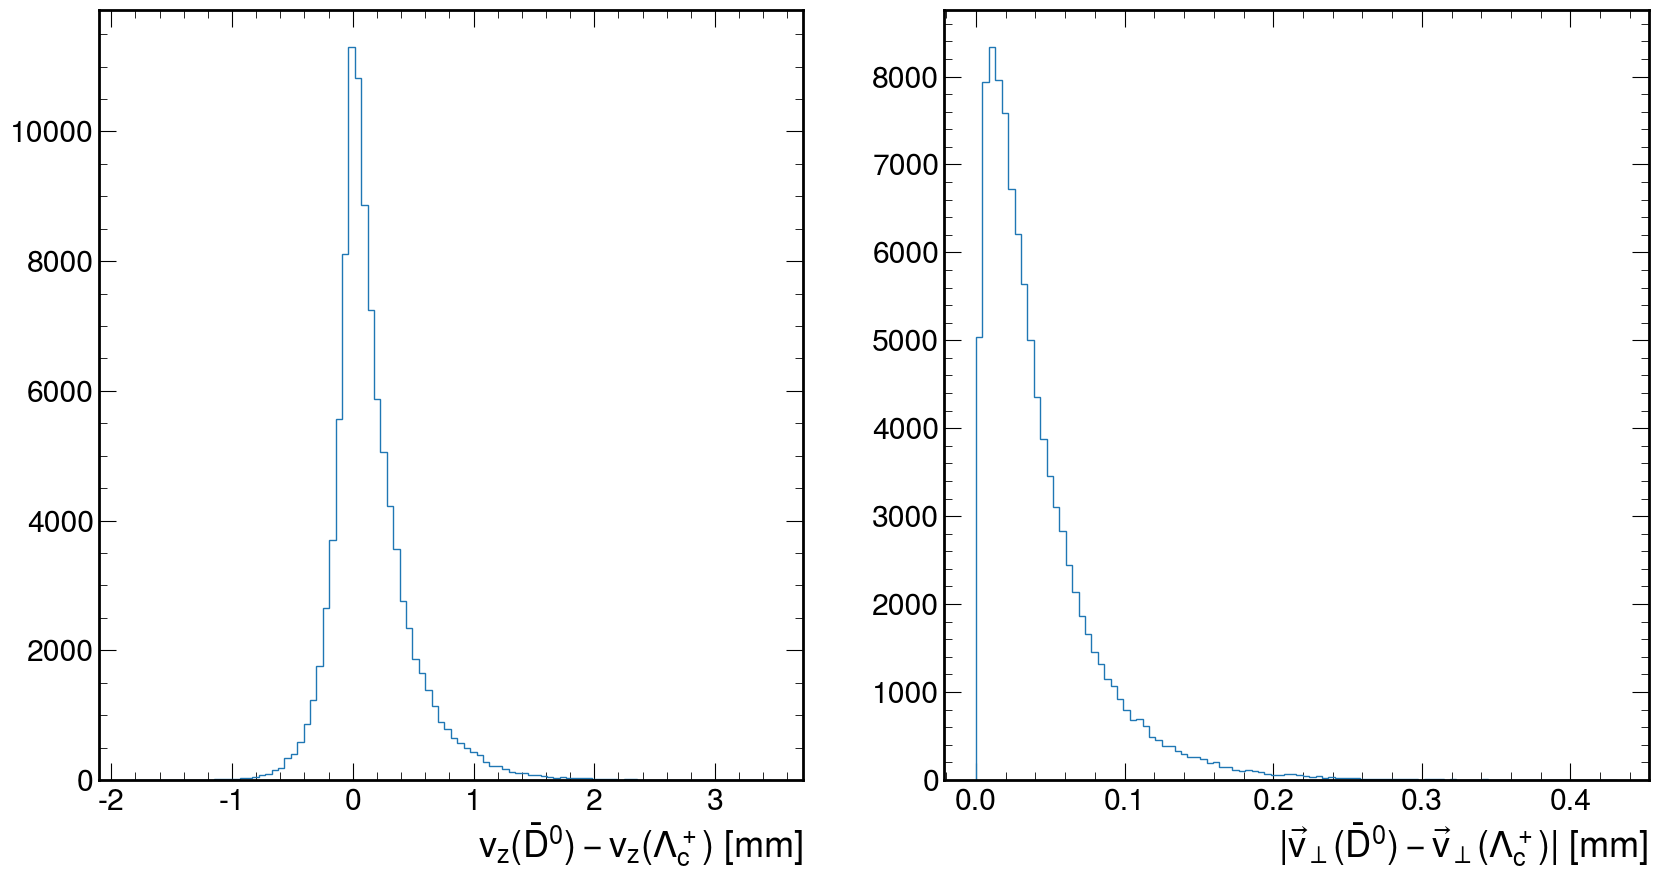

In [11]:
fig, axs=plt.subplots(1,2, figsize=(20,10))
plt.sca(axs[0])
plt.hist(df_sim.D0_vz-df_sim.lambdac_vz, bins=100, histtype='step', label="$\\bar D^0$")
plt.xlabel("$v_z(\\bar D^0)-v_z(\\Lambda_c^+)$ [mm]")
#plt.yscale('log')
#plt.legend()
plt.sca(axs[1])
plt.hist(df_sim.eval("sqrt((D0_vx-lambdac_vx)**2+(D0_vy-lambdac_vy)**2)"), bins=100, histtype='step')
plt.xlabel("$|\\vec v_\\perp(\\bar D^0)-\\vec v_\\perp(\\Lambda_c^+)|$ [mm]")
#plt.yscale('log')
plt.show()

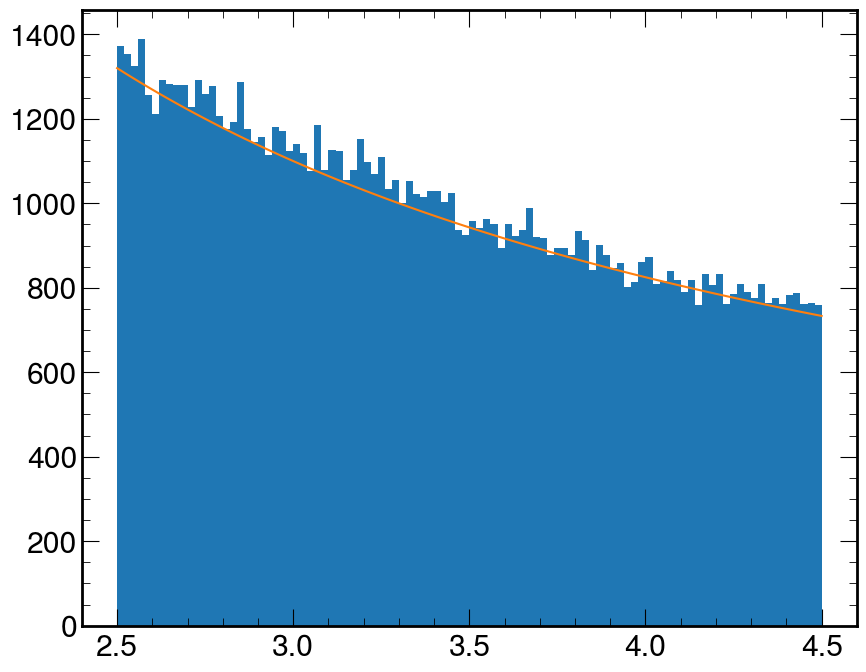

In [12]:
plt.hist(df_sim.e_theta*180/np.pi,bins=100)
x=np.linspace(2.5,4.5, 100)
plt.plot(x, 3300/x)
plt.show()

Text(1, 0, '$Q^2$ [GeV$^2$]')

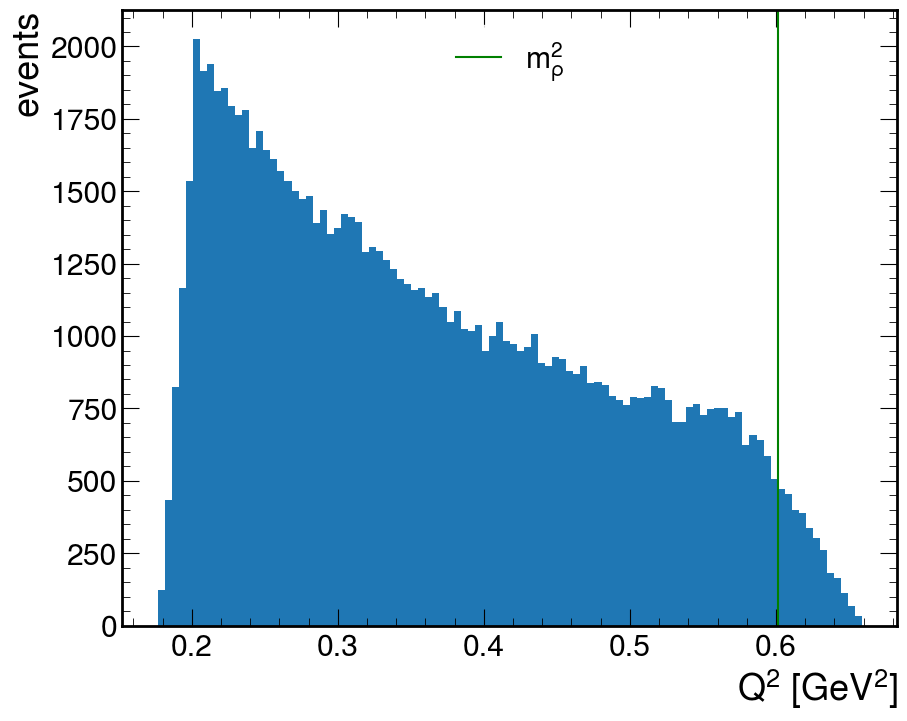

In [13]:
plt.hist(df_sim.eval("10.6*(10.6-e_E)*4*sin(e_theta/2)**2"), bins=100)
plt.axvline(pdg.GetParticle("rho0").Mass()**2, color='g', label='$m_{\\rho}^2$')
plt.legend()
plt.ylabel("events")
plt.xlabel("$Q^2$ [GeV$^2$]")

In [14]:
def df_frac(df, qnum, qdenom=None):
    if qdenom is None:
        return len(df.query(qnum))/len(df)
    if qdenom is None:
        return len(df.query(qnum+" and "+qdenom))/len(df.query(qdenom))

In [15]:
deg=np.pi/180
df_frac(df_sim, f"Kp_theta>5*{deg} and pim_theta>5*{deg} and Kp_theta<45*{deg} and pim_theta<45*{deg}"+\
        f" and Km_theta>5*{deg} and pip_theta>5*{deg} and Km_theta<45*{deg} and pip_theta<45*{deg}"+\
        f" and p_theta>5*{deg} and p_theta<45*{deg}"+\
       " and Kp_p<3 and pim_p<3 and pip_p<3 and p_p<3 and Km_p<3")

0.11535

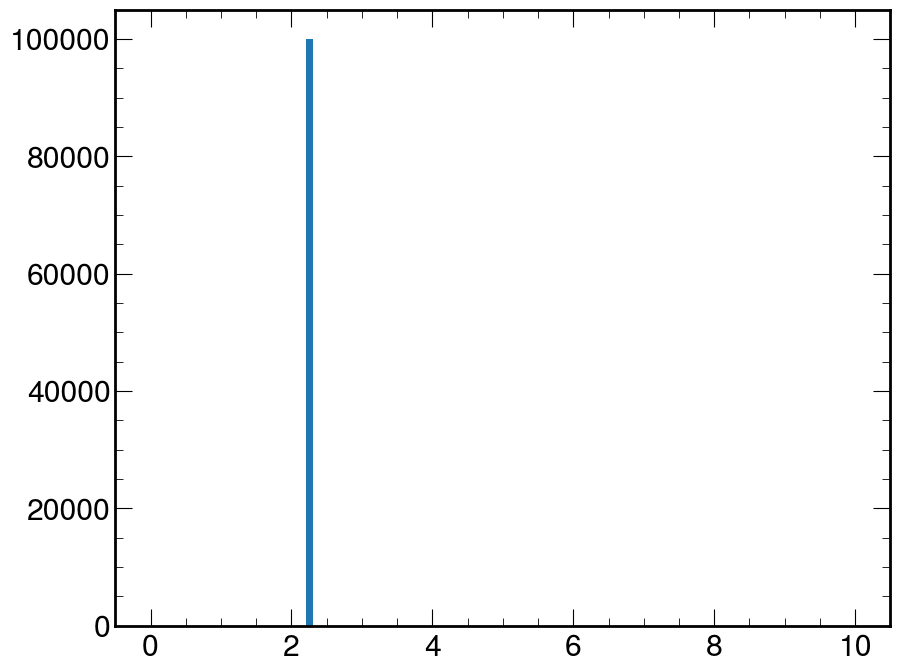

In [16]:
plt.hist(df_sim.eval("sqrt((Km_E+pip_E+p_E)**2-(Km_px+pip_px+p_px)**2-(Km_py+pip_py+p_py)**2-(Km_pz+pip_pz+p_pz)**2)"), bins=100, range=(0,10))
plt.show()

(array([     0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0., 100000.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
      

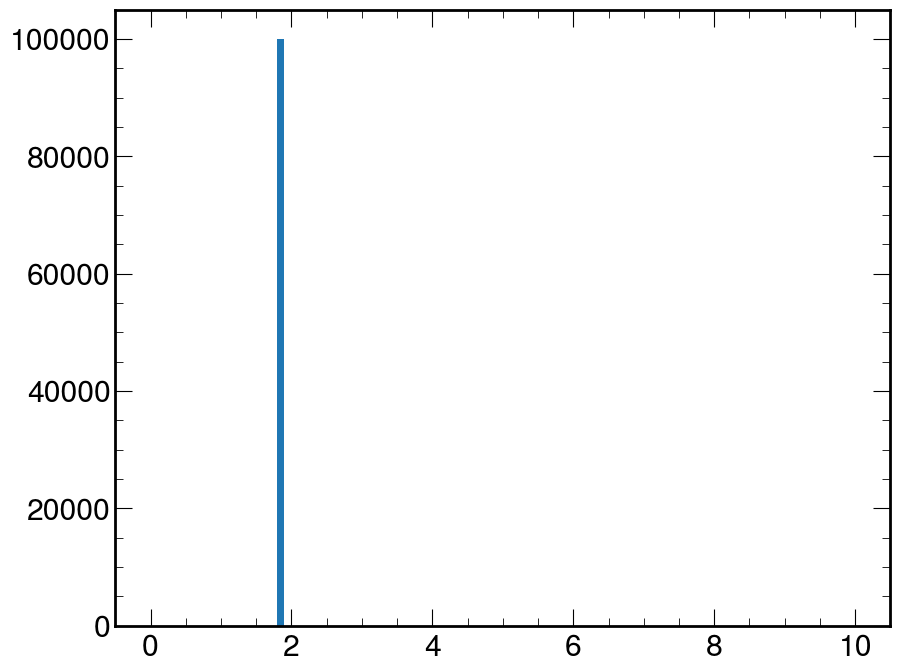

In [17]:
plt.hist(df_sim.eval("sqrt((Kp_E+pim_E)**2-(Kp_px+pim_px)**2-(Kp_py+pim_py)**2-(Kp_pz+pim_pz)**2)"), bins=100, range=(0, 10))

In [18]:
#check the event:
with open("D0bar_lcp_sim/D0bar_lcp_sim_0.lund", "r") as f:
    npart=int(f.readline().split()[0])
    parts={}
    for i in range(npart):
        line= f.readline().split()
        pid=int(line[3])
        parts[pid]=ROOT.TLorentzVector(*(float(a) for a in line[6:10]))
        #check that the mass matches the pdg value
        tol=0.001
        assert abs(float(line[10])-pdg.GetParticle(pid).Mass())<tol
        assert abs(float(line[10])-parts[pid].M())<tol
    #missing mass
    print((ROOT.TLorentzVector(0,0,10.6,10.6+pdg.GetParticle(2212).Mass())-parts[11]-parts[321]-parts[-211]).M())
    print((ROOT.TLorentzVector(0,0,10.6,10.6+pdg.GetParticle(2212).Mass())-parts[11]-parts[-321]-parts[211]-parts[2212]).M())
    print((parts[321]+parts[-211]).M())
    print((parts[-321]+parts[211]+parts[2212]).M())

2.2864008197018344
1.8647510771530897
1.8648399999999992
2.2864599999999986
